In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from facenet_pytorch import InceptionResnetV1
import torch.nn as nn
import torch
import tqdm
import numpy as np
import faiss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
embedding_model = InceptionResnetV1(pretrained='vggface2', classify=False).eval()
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [27]:
def get_mean_embeddings(dataloader, dataset, model):
    class_embeddings = {}
    class_names = dataset.classes

    class_embeddings = {
        int(class_idx): [] for class_idx in class_names
    }

    with torch.no_grad():
        for images, labels in tqdm.tqdm(dataloader):
            images = images.to(device)
            embeddings = model(images)
            
            for emb, label in zip(embeddings, labels):
                class_name = int(class_names[label.item()])
                class_embeddings[class_name].append(emb.cpu().numpy())

    avg_embeddings = {
        class_idx: np.mean(embeddings, axis=0)
        for class_idx, embeddings in sorted(class_embeddings.items())
    }

    return avg_embeddings

In [29]:
def save_embeddings(file_path, embeddings):
    np.savez_compressed(
        file_path,
        names=np.array(list(embeddings.keys())),
        embeddings=np.stack(list(embeddings.values()))
    )
def load_embeddings(file_path):
    saved_data = np.load(file_path)
    embeddings = dict(zip(saved_data['names'], saved_data['embeddings']))
    return embeddings
def create_faiss_index(embeddings: dict) -> faiss.IndexFlatIP:
    embeddings = {int(k): v for k, v in embeddings.items()}
    embeddings = dict(sorted(embeddings.items()))
    
    embedding_matrix = np.stack(list(embeddings.values())).astype('float32')
    faiss.normalize_L2(embedding_matrix)
    embedding_dim = embedding_matrix.shape[1]
    index = faiss.IndexFlatIP(embedding_dim)
    index.add(embedding_matrix)
    return index

In [5]:
dataset = datasets.ImageFolder(
    root="C:/face_dataset/imdb_train_large",
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
mean_embeddings = get_mean_embeddings(dataloader, dataset, embedding_model)
save_embeddings('C:/Proga/course_work/notebooks/data/large_embeddings.npz', mean_embeddings)

100%|██████████| 5322/5322 [43:34<00:00,  2.04it/s]


In [54]:
mean_embeddings=load_embeddings('data/large_embeddings.npz')
faiss_index = create_faiss_index(mean_embeddings)
faiss.write_index(faiss_index, "data/large_embeddings.faiss")

In [31]:
loaded_index = faiss.read_index("data/large_embeddings.faiss")

In [12]:
test_dataset = datasets.ImageFolder(
    root="C:/face_dataset/imdb_test_large",
    transform=transform
)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
test_embeddings = get_mean_embeddings(test_dataloader, test_dataset, embedding_model)
save_embeddings('C:/face_dataset/large_test_embeddings.npz', test_embeddings)

100%|██████████| 485/485 [03:01<00:00,  2.67it/s]


In [33]:
test_embeddings = load_embeddings('C:/face_dataset/large_test_embeddings.npz')

In [34]:
def top_accuracy_faiss(loaded_index, test_embeddings, top_len = 5):
    test_matrix = np.stack(list(test_embeddings.values())).astype('float32')
    names_list = list(int(name) for name in test_embeddings.keys())

    faiss.normalize_L2(test_matrix)
    
    D, I = loaded_index.search(test_matrix, top_len)

    unfinded_celebs = []
    correct = 0
    total = len(test_embeddings)
    
    true_indices = np.arange(len(test_embeddings))
    
    for i in range(len(test_matrix)):
        if np.isin(true_indices[i], I[i]).any():
            correct += 1
        else:
            unfinded_celebs.append(names_list[i])
    
    return correct / total, unfinded_celebs

In [41]:
accuracy, missing_celebs = top_accuracy_faiss(loaded_index, test_embeddings, 10)
print(f"Top-5 Accuracy: {accuracy:.2%}")

Top-5 Accuracy: 96.62%


In [42]:
class MobileNetV3Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = mobilenet_v3_small(pretrained=True, weights=MobileNet_V3_Small_Weights.DEFAULT)
        self.base_model.classifier = nn.Identity()
    def forward(self, x):
        x = self.base_model(x)
        return x

mobilenet_model = MobileNetV3Embedder()
mobilenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [43]:
mobilenet_dataset = datasets.ImageFolder(
    root="C:/face_dataset/imdb_train_large",
    transform=mobilenet_transform
)
mobilenet_dataloader = DataLoader(mobilenet_dataset, batch_size=32, shuffle=False)

In [44]:
mobile_mean_embeddings = get_mean_embeddings(mobilenet_dataloader, mobilenet_dataset, mobilenet_model)

100%|██████████| 5322/5322 [17:21<00:00,  5.11it/s]


In [45]:
mobile_faiss_index = create_faiss_index(mobile_mean_embeddings)
faiss.write_index(mobile_faiss_index, "data/large_mobile_embeddings.faiss")

In [46]:
mobile_faiss_index = faiss.read_index("data/large_mobile_embeddings.faiss")
mobile_faiss_index.ntotal

15495

In [47]:
mobilenet_test_dataset = datasets.ImageFolder(
    root="C:/face_dataset/imdb_test_large",
    transform=mobilenet_transform
)
mobilenet_test_dataloader = DataLoader(mobilenet_test_dataset, batch_size=32, shuffle=False)
mobile_faiss_index = faiss.read_index("data/large_mobile_embeddings.faiss")

In [48]:
mobile_test_embeddings = get_mean_embeddings(mobilenet_test_dataloader, mobilenet_test_dataset, mobilenet_model)
save_embeddings('C:/face_dataset/large_mobile_test_embeddings.npz', mobile_test_embeddings)

100%|██████████| 485/485 [00:50<00:00,  9.65it/s]


In [49]:
accuracy, missing_celebs = top_accuracy_faiss(mobile_faiss_index, mobile_test_embeddings, 10)
print(f"Top-5 Accuracy: {accuracy:.2%}")

Top-5 Accuracy: 74.06%


In [52]:
import pandas as pd
celebs_df = pd.read_csv('data/large_celeb_names.csv')
missing_df = celebs_df[celebs_df['id'].isin(missing_celebs)].copy()

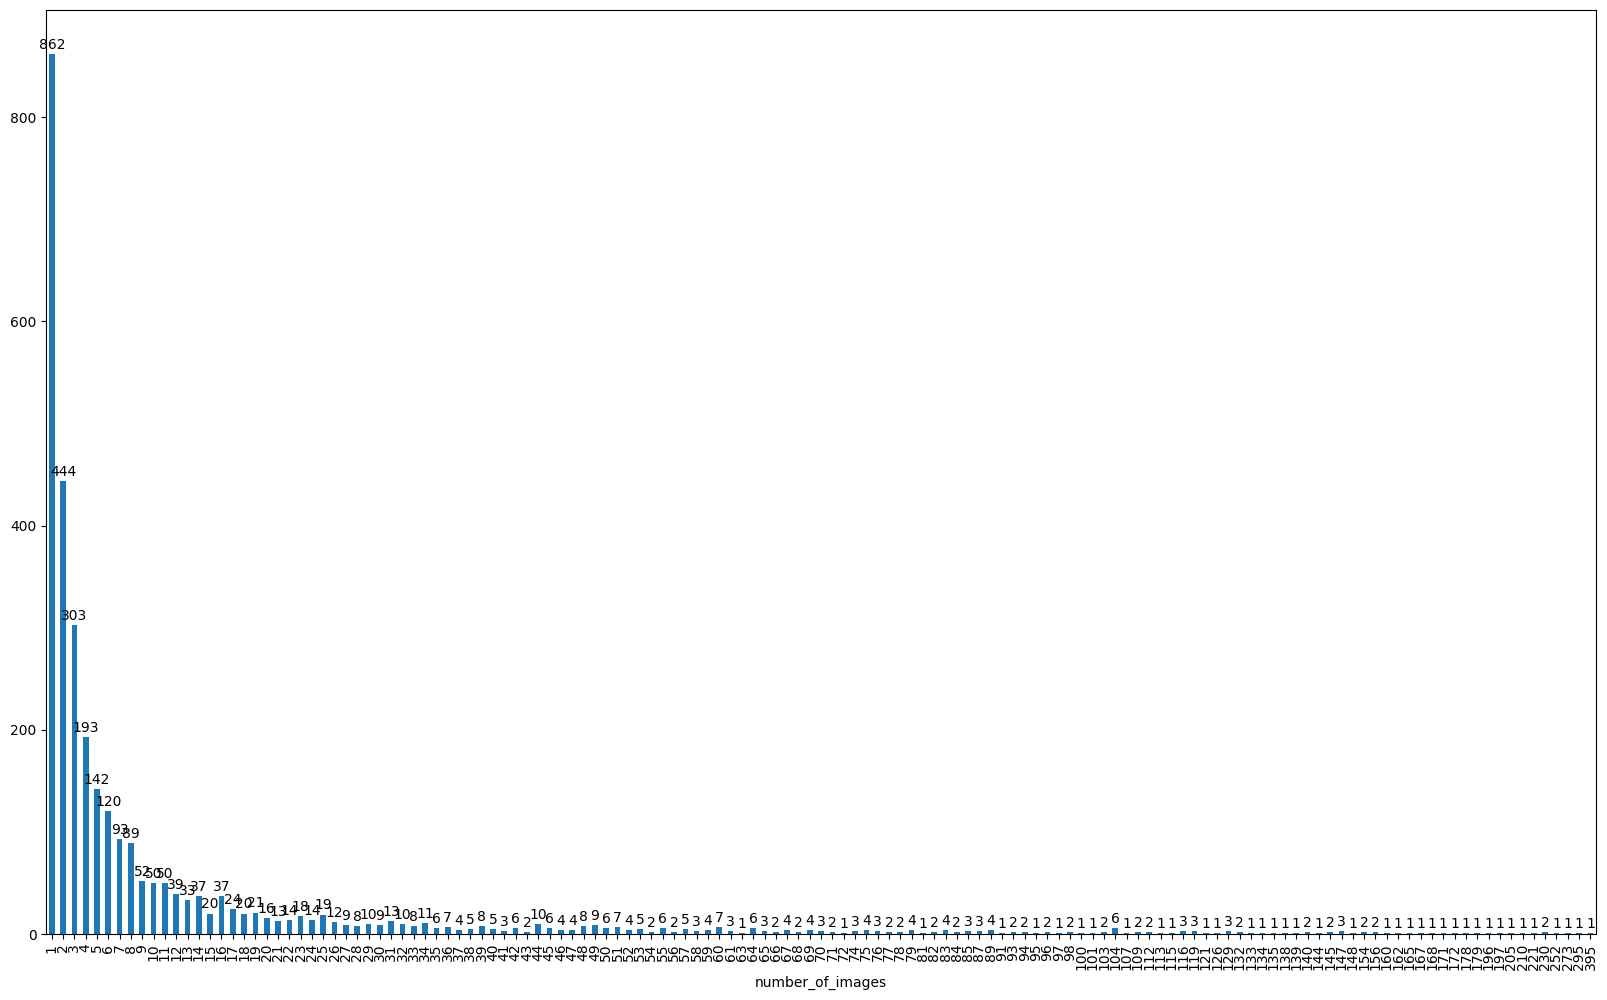

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
missing_df['number_of_images'].value_counts().sort_index().plot(kind='bar')

for i, count in enumerate(missing_df['number_of_images'].value_counts().sort_index()):
    plt.text(i, count + 5, str(count), ha='center')
plt.show()